# <center> Recommendation Systems for Amazon Electronic Products <center>

# 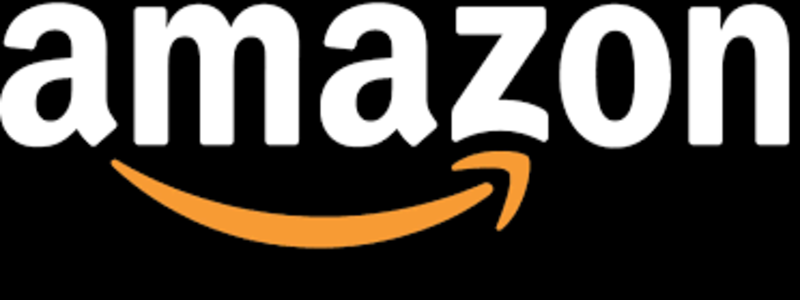

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Loading-Datasets" data-toc-modified-id="Loading-Datasets-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading Datasets</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Recommender-Systems" data-toc-modified-id="Recommender-Systems-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Recommender Systems</a></span><ul class="toc-item"><li><span><a href="#Popularity-Based-Recommender" data-toc-modified-id="Popularity-Based-Recommender-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Popularity-Based Recommender</a></span></li><li><span><a href="#Collaborative-Recommender" data-toc-modified-id="Collaborative-Recommender-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Collaborative Recommender</a></span><ul class="toc-item"><li><span><a href="#SVD:-Matrix-Factorization-Based-Algorithm" data-toc-modified-id="SVD:-Matrix-Factorization-Based-Algorithm-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>SVD: Matrix Factorization Based Algorithm</a></span></li></ul></li><li><span><a href="#Hybrid-Recommender" data-toc-modified-id="Hybrid-Recommender-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Hybrid Recommender</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Introduction

Online E-commerce websites like Amazon, Filpkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real time. This type of filtering matches each of the user's purchased and rated items to similar items, then combines those similar items into a recommendation list for the user. In this project we are going to build recommendation model for the electronics products of Amazon.


The main types of recommendations systems include:


-  **Popularity-Based Recommender**
   - It offers generalized recommendations to every user, based on product popularity. This system recommends same products to all users and it does not give personalized recommendations to users.


-  **Content-Based Recommender**
   - It builds an engine that computes similarity between products based on certain metrics such as description, and suggests products that are most similar to a particular product that a user liked. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.


-  **Collaborative Recommender**
   - This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filtering is based on the idea that users similar to a particular user can be used to predict how much that particular user will like a particular product or service those users have used/experienced but that particular user has not.


-  **Hybrid Recommender**
   - This system builds an ensemble of Collaborative, Content-Based or Popularity-Based models to come up with a comprehensive Hybrid Recommendation System.
   

Amazon Reviews data source has several datasets. For this case study, we are using the Electronics dataset which includes:
-  userId : Every user identified with a unique id
-  productId : Every product identified with a unique id
-  Rating : Rating of the corresponding product by the corresponding user
-  timestamp : Time of the rating ( ignore this column for this exercise)


Our objective is to build a recommendation system to recommend products to customers based on the their previous ratings for other products. For this purpose, first we will perform exploratory data analysis and then implement three recommendation algorithms including Popularity-Based, Collaborative, and Hybrid Recommenders.

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

## Loading Datasets

In [ ]:
column_names=['userId','productId','rating','timestamp']
df=pd.read_csv('../input/amazon-product-reviews/ratings_Electronics (1).csv',names=column_names)

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

We can see that there is no missing data and the data is clean.

## Exploratory Data Analysis 

First we analyze the number of recorded ratings.

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=df, palette='winter')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Number of Each Rating', fontsize=15)
plt.show()

We can see that most of users rated 5 for the products.

We study the distribuition of number of ratings and mean ratings recorded for each product.

In [ ]:
df_rating=pd.DataFrame({'Number of Rating':df.groupby('productId').count()['rating'], 'Mean Rating':df.groupby('productId').mean()['rating']})

In [ ]:
df_rating.head()

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.hist(x='Number of Rating',data=df_rating,bins=30,color='teal')
plt.title('Distribution of Number of Rating', fontsize=15)
plt.xlabel('Number of Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1,2,2)
plt.hist(x='Mean Rating',data=df_rating,bins=30, color='slateblue')
plt.title('Distribution of Mean Rating', fontsize=15)
plt.xlabel('Mean Rating', fontsize=12)
plt.yticks([])
plt.show()

From these histograms we can see that most of the number of ratings are between 0 and 1825, and most of the products have a mean rating of 5.

We create a scatter plot to observe the relationship between Number of Rating and Mean Rating.

In [ ]:
plt.figure(figsize=(8,6))
sns.jointplot(x='Number of Rating', y='Mean Rating',data=df_rating,color='g', height=7)
plt.suptitle('Mean Rating Versus Number of Rating', fontsize=15, y=0.92)

plt.show()

## Recommender Systems

### Popularity-Based Recommender 

The implementation of Popularity-Based Filtering is straighforward. All we have to do is sort our products based on ratings, and display the top products of our list. Therefore, we should;

- Create a metric to score or rate the products.
- Calculate the score for every product.
- Sort the scores and recommend the best rated product to the users.

We can use the average ratings of the products as the score but using this will not be fair enough since a product with 5average rating and only43 votes cannot be considered better than the product with 4 as average rating but 40 votes. So, we use IMDB's weighted rating formula to score the products, as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$ 

- v: the number of votes for the product

- m: the minimum votes required to be listed in the chart

- R: the average rating of the product

- C: the mean vote across the whole report

Based on the df_rating dataframe created above, we already have v or the Number of Rating, and R or Mean Rating for each product. So we calculate C.

In [ ]:
df_rating['Mean Rating'].mean()

The mean rating for all the products (C) is approximately 3.9 on a scale of 5.

The next step is to determine an appropriate value for m, the minimum number of votes required for a product to be listed in the chart. We use 90th percentile as our cutoff. In other words, for a product to feature in the charts, the number of its votes should be higher than that of 90% of the products in the list.

In [ ]:
df_rating['Number of Rating'].quantile(q=0.9)

Now, we filter the products that qualify for the chart and put them in a new dataframe called df_filtered.

In [ ]:
df_filtered=df_rating[df_rating['Number of Rating']>df_rating['Number of Rating'].quantile(q=0.9)]

In [ ]:
df_filtered.shape

We see that there are 46553 products which qualify to be in this list.

Now, we calculate score for each qualified product. To do this, we define a function, weighted_rating(), and apply this function to the DataFrame of qualified products.

In [ ]:
def product_score(x):
    v=x['Number of Rating']
    m=df_rating['Number of Rating'].quantile(q=0.9)
    R=x['Mean Rating']
    C=df_rating['Mean Rating'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [ ]:
df_filtered['score']=df_filtered.apply(product_score, axis=1)

In [ ]:
df_filtered.head()

Finally, we sort the dataframe based on the score feature, and we output the the top 10 popular products.

In [ ]:
df_highscore=df_filtered.sort_values(by='score', ascending=False).head(10)

In [ ]:
df_highscore

In [ ]:
df_highscore.index

So the top 10 popular products that this model will recommend to users include 'B0043WJRRS', 'B00CG70K78', 'B007SZ0E1K', 'B003FVVMS0', 'B0033PRWSW','B008VGCT9K', 'B0029N3U8K', 'B0041OYTJE', 'B00GMRCAC6' and 'B007R5YGO2'.

We should keep in mind that this popularity-based recommender provides a general chart of recommended products to all the users, regardless of the user's personal taste. It is not sensitive to the interests and tastes of a particular user, and it does not give personalized recommendations based on the users.

### Collaborative Recommender

Our popularity-based recommender engine suffers from some severe limitations. It is not really personal and does not capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a product will receive the same recommendations for that product, regardless of who she/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make better recommendations to Amazon customers.

Collaborative Filtering matches persons with similar interests and provides recommendations based on this matching. It is based on the idea that users similar to me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not. 

Surprise library is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Here we use the Surprise library that uses extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise Root Mean Square Error (RMSE) that is measured by Kfold Cross Validation and give great recommendations.

#### SVD: Matrix Factorization Based Algorithm

Here we will use the famous SVD algorithm.

In [ ]:
svd = SVD()

In [ ]:
reader = Reader()

Now we load the df dataset.

In [ ]:
data = Dataset.load_from_df(df[['userId', 'productId', 'rating']], reader)

Then we run 5-fold cross-validation and print the results.

In [ ]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

We get a mean Root Mean Sqaure Error of 1.29 approx which is good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()

We train the algorithm on the trainset.

In [ ]:
svd.fit(trainset)

Let us pick the user with userId of 'AKM1MP6P0OYPR' and check the ratings she/he has given so far to different products.

In [ ]:
df[df['userId'] == 'AKM1MP6P0OYPR']

As an example, we use the algorithm to predict the score that might be given to the productId of '0970407998' by this specific userId.

In [ ]:
svd.predict(uid='A17HMM1M7T9PJ1', iid='0970407998', r_ui=None)

In [ ]:
svd.predict(uid='A17HMM1M7T9PJ1', iid='0970407998', r_ui=None).est

Our model predicts that userId of 'A17HMM1M7T9PJ1' will give 3.89 as the rating for productId of '0970407998'.

### Hybrid Recommender

In this section, we try to build a hybrid recommender that combines corrwith() method which computes the Pearson correlation coefficients with collaborative filtering. This is how it works:

-  Input: User ID and Product ID

-  Output: Similar products sorted on the basis of expected ratings by a particular user.

First, we create a pivot table which contains userIds as rows and productIds as columns. However, if we use the whole datafram (df) in the below code, there will be an error because the input data has more than 7 million rows.

The below code will give an error:
matrix=pd.pivot_table(data=df, values='rating', index='userId',columns='productId')

To avoid processing difficulties, we filter data which only contains the customers who have given ratings more than 50 times and put them into a dataframe. Since we are providing the recommendation of the products to the customers, it is better to remove data based on the userId rather than productId.

In [ ]:
df_users=df.groupby('userId').filter(lambda x: x['rating'].count()>=50)

In [ ]:
df_users.head()

In [ ]:
df_users.shape

Then we create a pivot table.

In [ ]:
matrix=pd.pivot_table(data=df_users, values='rating', index='userId',columns='productId')

In [ ]:
matrix.head()

Finally we define a function that takes in productId and useId as input and outputs up to 5 most similar products. For this purpose, we use corrwith() method to compute pairwise correlation between columns of dataFrame and calculate Pearson correlation coefficients.

In [ ]:
# Function that takes in productId and useId as input and outputs up to 5 most similar products.
def hybrid_recommendations(userId, productId):
    
    # Get the Id of the top five products that are correlated with the ProductId chosen by the user.
    top_five=matrix.corrwith(matrix[productId]).sort_values(ascending=False).head(5)
    
    # Predict the ratings the user might give to these top 5 most correlated products.
    est_rating=[]
    for x in list(top_five.index):
        if str(top_five[x])!='nan':
            est_rating.append(svd.predict(userId, iid=x, r_ui=None).est)
           
    return pd.DataFrame({'productId':list(top_five.index)[:len(est_rating)], 'estimated_rating':est_rating}).sort_values(by='estimated_rating', ascending=False).reset_index(drop=True)

As an example, we use this hybrid function to recommend similar products and predict the scores that might be given by a specific user to these similar products. It should be noted that this function was defined bassed on df_users dataframe that only includes the users who have rated 50 times or more. Now, we check the performance of this hybrid recommender for some of the userIds included in df_users dataframe.

In [ ]:
hybrid_recommendations('A2NYK9KWFMJV4Y', 'B00LI4ZZO8')

## Conclusion

We built three different recommendation systems based on different algorithms. They are as follows:

-   **Popularity-Based Recommender:** This system used the overall Number of Rating and VMean Rating to find the top 10 productIds. The IMDB Weighted Rating System was used to calculate scores on which the sorting was finally performed.



-   **Collaborative Filtering:** We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was about 1.29 and the engine predicted estimated ratings for a given user and product.


-   **Hybrid Engine:** We combined corrwith() method which computed the Pearson correlation coefficients with collaborative filtering. Our hybrid recommender took useId and productId as input and suggested up to 5 products that were similar to the input productId based on the estimated ratings that was internally calculated for the input userId. This Hybrid System took advantage of both Pearson method and Collaborative filtering and therefore made reliable predictions.